In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

data = pd.read_csv('updated_cleaned_patient_data.csv')
feature_cols = [
    'FBS', 'BMI', 'Diabetes', 'age', 'hypertension',
    'vegetarian (1= yes, 0=no)', 'Exercise (min/week)',
    'Cholesterol', 'Living_Area_Code', 'Marriage_Status_Code'
]
X = data[feature_cols].fillna(0)
y = data['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import time # เอาไว้จับเวลาเล่นๆ

# 1. ตั้งค่า Parameter แบบจัดเต็ม
# range(1, 1001) จะสร้างตัวเลขตั้งแต่ 1 ถึง 1000
param_grid = {
    'n_neighbors': list(range(1, 500)), 
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# 2. สร้าง Grid Search พร้อมเปิดพลังเทอร์โบ
# n_jobs=-1 : คำสั่งสำคัญ! บอกให้ใช้ CPU ทุก Core ที่มี (คอมแรงต้องใช้ตัวนี้)
# verbose=1 : ให้มันปริ้นท์บอกสถานะหน่อย จะได้รู้ว่ายังทำงานอยู่ (เลขยิ่งเยอะยิ่งละเอียด)
knn = KNeighborsClassifier()
grid_search = GridSearchCV(
    estimator=knn, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,  # <--- ใช้ทุก Core
    verbose=1   # <--- แสดง Progress
)

print("Start Training... (เครื่องแรงแค่นี้ สบายมาก!)")
start_time = time.time()

# 3. เริ่มรัน (ระวัง! จำนวนแถวข้อมูล Train ต้องมากกว่า 1000 นะครับ ไม่งั้น Error)
grid_search.fit(X_train_scaled, y_train)

end_time = time.time()
print(f"Training Completed in {end_time - start_time:.2f} seconds")

# ==========================================
# 4. ดูผลลัพธ์
# ==========================================
print("\n--- The Winner is ---")
print("Best Accuracy:", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)

# เซฟผลทั้งหมดลง CSV (ไฟล์อาจจะใหญ่นิดนึง เพราะมี 4000 rows)
results_df = pd.DataFrame(grid_search.cv_results_)
results_df[['param_n_neighbors', 'param_weights', 'param_p', 'mean_test_score', 'rank_test_score']] \
    .sort_values(by='rank_test_score') \
    .to_csv('knn_full_grid_search_1_to_1000.csv', index=False)

print("Saved results to 'knn_full_grid_search_1_to_1000.csv'")

Start Training... (เครื่องแรงแค่นี้ สบายมาก!)
Fitting 5 folds for each of 1996 candidates, totalling 9980 fits
Training Completed in 10.19 seconds

--- The Winner is ---
Best Accuracy: 0.7825
Best Params: {'n_neighbors': 24, 'p': 1, 'weights': 'uniform'}
Saved results to 'knn_full_grid_search_1_to_1000.csv'


กำลังทดสอบ Alpha ทั้งหมด 53 ค่า...


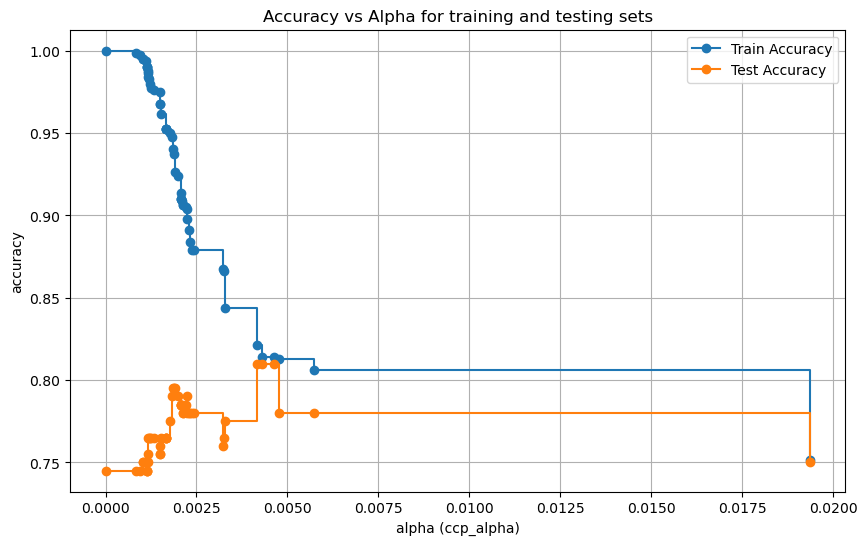

In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 1. สร้างโมเดลเปล่าๆ เพื่อหา "เส้นทางของ Alpha" (Candidate Alphas)
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas  # นี่คือค่า Alpha ทั้งหมดที่น่าสนใจ
ccp_alphas = ccp_alphas[:-1]  # ตัดตัวสุดท้ายทิ้ง (เพราะมันคือ Alpha ที่ตัดจนเหลือแต่ราก)

# 2. วนลูปสร้างโมเดลสำหรับ Alpha แต่ละค่า
clfs = []
train_acc = []
test_acc = []

print(f"กำลังทดสอบ Alpha ทั้งหมด {len(ccp_alphas)} ค่า...")

for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    
    # เก็บค่า Accuracy
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))

# 3. วาดกราฟเปรียบเทียบ
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_acc, marker='o', label="Train Accuracy", drawstyle="steps-post")
plt.plot(ccp_alphas, test_acc, marker='o', label="Test Accuracy", drawstyle="steps-post")
plt.xlabel("alpha (ccp_alpha)")
plt.ylabel("accuracy")
plt.title("Accuracy vs Alpha for training and testing sets")
plt.legend()
plt.grid()
plt.show()

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# สมมติว่า y_pred คือผลที่ทำนายได้ และ y คือเฉลยจริง (y_test)
# คุณต้องรัน model.predict มาก่อนถึงจะได้ y_pred นะครับ
# y_pred = model.predict(X_test) 

acc = round(accuracy_score(y_test, y_pred), 2) # ในรูปใช้ตัวแปร y แต่ปกติเราจะใช้ y_test
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="rocket") # fmt=".0f" คือไม่เอาทศนิยม
plt.xlabel('custcat_predict') # แกน X คือสิ่งที่ทำนาย
plt.ylabel('custcat')         # แกน Y คือของจริง
plt.title('Accuracy Score: {0}'.format(acc), size=10)
plt.show()

NameError: name 'y_pred' is not defined

ค่า K ที่ดีที่สุดคือ: [23]


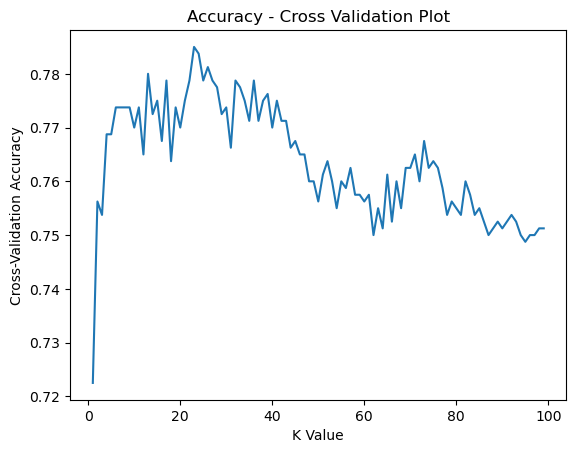

In [15]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# กำหนดช่วง K ที่ต้องการทดสอบ (1 ถึง 99)
k_values = range(1, 100)
cv_scores = []

# เริ่มวนลูปทดสอบทีละค่า
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    # cv=5 คือแบ่งเทส 5 รอบแล้วหาค่าเฉลี่ย
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# --- หาค่า K ที่ให้ผลลัพธ์ดีที่สุด (Optimal K) ---
optimal_k_values = [k_values[i] for i in range(len(cv_scores)) if cv_scores[i] == max(cv_scores)]
print("ค่า K ที่ดีที่สุดคือ:", optimal_k_values)

# --- วาดกราฟแสดงผล ---
plt.plot(k_values, cv_scores)
plt.xlabel('K Value')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Accuracy - Cross Validation Plot')
plt.show()

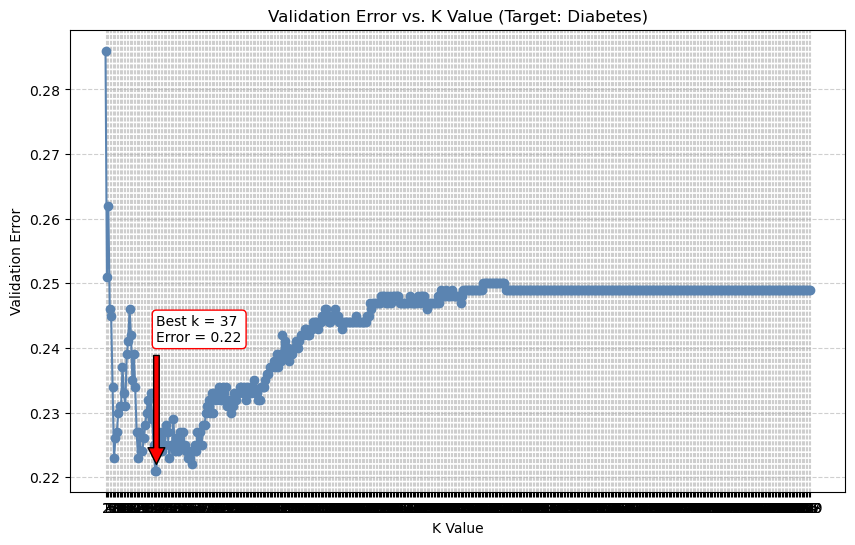

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 1. โหลดข้อมูล
df = pd.read_csv('updated_cleaned_patient_data.csv')

# 2. เตรียมข้อมูล (Preprocessing)
# แยก Features (X) และ Target (y) -> สมมติให้ทำนาย 'Diabetes'
df = pd.read_csv('updated_cleaned_patient_data.csv')

feature_cols = [
    'FBS', 'BMI', 'Diabetes', 'age', 'hypertension',
    'vegetarian (1= yes, 0=no)', 'Exercise (min/week)',
    'Cholesterol', 'Living_Area_Code', 'Marriage_Status_Code'
]

X = df[feature_cols].fillna(0)

y = df['stroke']

# ปรับสเกลข้อมูล (Scaling) *สำคัญมากสำหรับ KNN*
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. ทดลองหาค่า k ตั้งแต่ 1 ถึง 20
k_range = range(1, 101)
k_scores = []

# ใช้ Cross-Validation (10-fold) เพื่อหา Error เฉลี่ยของแต่ละ k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k,p=2)
    # cross_val_score ให้ค่า accuracy เราจึงเอา 1 - accuracy เพื่อหา error
    scores = cross_val_score(knn, X_scaled, y, cv=10, scoring='accuracy')
    k_scores.append(1 - scores.mean())

# หาค่า k ที่ Error ต่ำที่สุด
best_k = k_range[np.argmin(k_scores)]
min_error = min(k_scores)

# 4. พล็อตกราฟ
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o', linestyle='-', color='#5b84b1')
plt.title('Validation Error vs. K Value (Target: Diabetes)')
plt.xlabel('K Value')
plt.ylabel('Validation Error')
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.6)

# ชี้จุดที่ดีที่สุด
plt.annotate(f'Best k = {best_k}\nError = {min_error:.2f}', 
             xy=(best_k, min_error), 
             xytext=(best_k, min_error + 0.02),
             arrowprops=dict(facecolor='red', shrink=0.05),
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1))

plt.show()